<a href="https://colab.research.google.com/github/mdsiam135/ICCIT2025/blob/main/Transformer(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# -*- coding: utf-8 -*-
# Transformer for Crop Production Classification

# This script demonstrates how to build and train a Transformer model
# for classifying crop production levels based on tabular data using TensorFlow/Keras.

## 1. Setup and Imports

# Import necessary libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score # Added f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (optional, if data is stored there)
# from google.colab import drive
# drive.mount("/content/drive")

# Define file paths (adjust if using Google Drive or local upload)
# Example for uploaded files in Colab:
TRAIN_PATH = "/content/drive/MyDrive/UpdatedDataset/training.csv"
VALID_PATH = "/content/drive/MyDrive/UpdatedDataset/validating.csv"
TEST_PATH = "/content/drive/MyDrive/UpdatedDataset/testing.csv"

# Example for Google Drive:
# DRIVE_PATH = "/content/drive/MyDrive/your_folder/"
# TRAIN_PATH = DRIVE_PATH + "train.csv"
# VALID_PATH = DRIVE_PATH + "validation.csv"
# TEST_PATH = DRIVE_PATH + "test.csv"



In [13]:




## 2. Load and Preprocess Data

# Load the datasets and apply preprocessing steps.
def load_and_preprocess(file_path, scaler=None, fit_scaler=False, label_encoder=None, fit_encoder=False):
    """Loads data, preprocesses features, and converts target to classes."""
    df = pd.read_csv(file_path)

    # Define class boundaries based on quantiles (6 classes)
    # Calculate quantiles on training data only (to avoid data leakage)
    if fit_scaler:  # Only calculate quantiles for training data
        global quantile_bins
        quantiles = df["Production (M.Ton)"].quantile([0.16667, 0.33333, 0.5, 0.66667, 0.83333]).values
        quantile_bins = [-np.inf] + quantiles.tolist() + [np.inf]
        print(f"Quantile boundaries: {quantile_bins}")

    bins = quantile_bins
    labels = [0, 1, 2, 3, 4, 5] # Very Low, Low, Medium, High, Very High, Extremely High

    # Convert target variable to classes
    df["Production_Class"] = pd.cut(df["Production (M.Ton)"], bins=bins, labels=labels, right=True)

    # Separate features and target
    X = df.drop(["Production (M.Ton)", "Production_Class"], axis=1)
    y = df["Production_Class"]

    # Identify numerical features (excluding one-hot encoded Crop and District)
    # Assuming columns starting with 'Crop_' or 'District_' are one-hot encoded
    numerical_cols = [col for col in X.columns if not col.startswith("Crop_") and not col.startswith("District_")]

    # Scale numerical features
    if fit_scaler:
        scaler = StandardScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided if fit_scaler is False")
        X[numerical_cols] = scaler.transform(X[numerical_cols])

    # Encode labels
    if fit_encoder:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
    else:
        if label_encoder is None:
            raise ValueError("LabelEncoder must be provided if fit_encoder is False")
        y_encoded = label_encoder.transform(y)

    # Convert labels to one-hot encoding
    y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(labels))

    # Return features as a flat numpy array (samples, features)
    X_flat = X.values

    if fit_scaler and fit_encoder:
        return X_flat, y_one_hot, scaler, label_encoder
    elif fit_scaler:
         return X_flat, y_one_hot, scaler
    elif fit_encoder:
        return X_flat, y_one_hot, label_encoder
    else:
        return X_flat, y_one_hot

# Initialize global variable for quantile bins
quantile_bins = None

# Load and preprocess data
print("Loading and preprocessing training data...")
X_train, y_train, scaler, label_encoder = load_and_preprocess(TRAIN_PATH, fit_scaler=True, fit_encoder=True)
print("Loading and preprocessing validation data...")
X_val, y_val = load_and_preprocess(VALID_PATH, scaler=scaler, label_encoder=label_encoder)
print("Loading and preprocessing test data...")
X_test, y_test = load_and_preprocess(TEST_PATH, scaler=scaler, label_encoder=label_encoder)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Number of classes: {y_train.shape[1]}")




Loading and preprocessing training data...
Quantile boundaries: [-inf, 417.0, 996.9507299999993, 2027.0, 3717.04927, 7522.611849200001, inf]
Loading and preprocessing validation data...
Loading and preprocessing test data...
Training data shape: (4928, 85), Labels shape: (4928, 6)
Validation data shape: (1056, 85), Labels shape: (1056, 6)
Test data shape: (1056, 85), Labels shape: (1056, 6)
Number of classes: 6


In [14]:


## 3. Build the Transformer Model

# Define the Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Corrected call method: pass 'training' argument to sub-layers
    def call(self, inputs, training=None): # Allow training=None for inference
        # Pass training argument to MultiHeadAttention
        attn_output = self.att(inputs, inputs, training=training)
        # Pass training argument to Dropout 1
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # Pass training argument to the Sequential FFN
        ffn_output = self.ffn(out1, training=training)
        # Pass training argument to Dropout 2
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the Transformer model building function
def build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_transformer_blocks, num_classes, dropout_rate=0.1):
    """Builds the Transformer model for tabular data."""
    num_features = input_shape[0]
    inputs = keras.Input(shape=input_shape)

    # --- Feature Embedding and Positional Encoding ---
    # Project features to embedding dimension
    x = layers.Dense(num_features * embed_dim, activation='relu')(inputs) # Project
    x = layers.Reshape((num_features, embed_dim))(x) # Reshape to (batch, seq_len=num_features, embed_dim)

    # Add learnable positional embedding
    position_embedding_layer = layers.Embedding(input_dim=num_features, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_features, delta=1)
    position_embeddings = position_embedding_layer(positions)
    x = x + position_embeddings
    # Pass training argument to Dropout after embedding
    x = layers.Dropout(dropout_rate)(x) # Keras handles training arg here implicitly in functional API
    # ----------------------------------------------------

    # --- Transformer Blocks ---
    for _ in range(num_transformer_blocks):
        # Keras handles passing the 'training' context implicitly here in functional API
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    # -------------------------

    # --- Classifier Head ---
    x = layers.GlobalAveragePooling1D()(x) # Pool across the feature dimension
    # Pass training argument to Dropout layers
    x = layers.Dropout(0.1)(x) # Keras handles training arg here implicitly
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x) # Keras handles training arg here implicitly
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    # -----------------------

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- Hyperparameters ---
EMBED_DIM = 32  # Embedding dimension for each feature position
NUM_HEADS = 4   # Number of attention heads
FF_DIM = 32     # Hidden layer size in feed forward network inside transformer
NUM_TRANSFORMER_BLOCKS = 2 # Number of transformer blocks
DROPOUT_RATE = 0.1
# -----------------------

# Get input shape and number of classes from preprocessed data
input_shape = (X_train.shape[1],) # Shape is (num_features,)
num_classes = y_train.shape[1]

# Build the model
model = build_transformer_model(
    input_shape,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE
)

# Compile the model
# Consider using AdamW or a lower learning rate for Transformers
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Print model summary
model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2720)           │       233,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 85, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_1 (Add)                     │ (None, 85, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 85, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 85, 32)         │        19,040 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 85, 32)         │        19,040 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,502 (1.05 MB)

 Trainable params: 274,502 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:


## 4. Train the Model

# Train the Transformer using the training and validation datasets.

# Define training parameters
EPOCHS = 100 # Transformers might need more epochs, adjust as needed
BATCH_SIZE = 64

# Add Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True) # Increased patience

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)




Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - accuracy: 0.1898 - loss: 1.8227 - val_accuracy: 0.2907 - val_loss: 1.7117
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.3000 - loss: 1.7000 - val_accuracy: 0.4006 - val_loss: 1.5639
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.4290 - loss: 1.5257 - val_accuracy: 0.4924 - val_loss: 1.3053
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.4920 - loss: 1.2909 - val_accuracy: 0.5616 - val_loss: 1.1030
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.5650 - loss: 1.0992 - val_accuracy: 0.6222 - val_loss: 0.9748
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.6188 - loss: 0.9793 - val_accuracy: 0.6297 - val_loss: 0.8874
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.6441 - loss: 0.8976 - val_accuracy: 0.6799 - val_loss: 0.8164
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.6974 - loss: 0.8043 - 

In [16]:


## 5. Evaluate the Model

# Get best validation accuracy from history
# Check if 'val_accuracy' exists in history (it should if validation_data is provided)
if 'val_accuracy' in history.history:
    best_val_accuracy = max(history.history['val_accuracy'])
    print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
else:
    print("\nValidation accuracy not available in history.")

# === NEW: VALIDATION SET EVALUATION ===
print("\n" + "="*50)
print("VALIDATION SET EVALUATION")
print("="*50)

# Evaluate on validation data
print("\nEvaluating model on validation data...")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions on validation set
print("\nGenerating predictions on validation data...")
y_val_pred_proba = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Convert one-hot encoded y_val back to single labels for comparison
y_val_labels = np.argmax(y_val, axis=1)

# Get class names from label encoder
class_names = label_encoder.classes_

# Define meaningful class names for display
class_display_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']

# Print Classification Report for Validation Set
print("\nValidation Set Classification Report (includes Recall and F1-score):")
print(classification_report(y_val_labels, y_val_pred, target_names=class_display_names))

# Calculate and print Macro F1 Score for Validation Set
val_macro_f1 = f1_score(y_val_labels, y_val_pred, average='macro')
print(f"\nMacro F1 Score (Validation Set): {val_macro_f1:.4f}")

# Print Confusion Matrix for Validation Set
print("\nValidation Set Confusion Matrix:")
val_cm = confusion_matrix(y_val_labels, y_val_pred)
print(val_cm)

# === END: VALIDATION SET EVALUATION ===




Best Validation Accuracy: 0.8598

VALIDATION SET EVALUATION

Evaluating model on validation data...
Validation Loss: 0.4330
Validation Accuracy: 0.8570

Generating predictions on validation data...
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Validation Set Classification Report (includes Recall and F1-score):
                precision    recall  f1-score   support

      Very Low       0.91      0.96      0.94       188
           Low       0.88      0.81      0.84       181
        Medium       0.75      0.83      0.79       170
          High       0.83      0.78      0.81       176
     Very High       0.85      0.82      0.83       171
Extremely High       0.91      0.93      0.92       170

      accuracy                           0.86      1056
     macro avg       0.86      0.86      0.86      1056
  weighted avg       0.86      0.86      0.86      1056


Macro F1 Score (Validation Set): 0.8557

Validation Set Confusion Matrix:
[[181   7   0   0   0   0]
 [ 16 147  17   0   1   0]

In [17]:



# === TEST SET EVALUATION ===
print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)

# Evaluate the trained model on the test dataset.
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
print("\nGenerating predictions on test data...")
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert one-hot encoded y_test back to single labels for comparison
y_test_labels = np.argmax(y_test, axis=1)

# Print Classification Report (includes Recall and F1-score per class, and macro/weighted averages)
print("\nTest Set Classification Report (includes Recall and F1-score):")
print(classification_report(y_test_labels, y_pred, target_names=class_display_names))

# Calculate and print Macro F1 Score separately
macro_f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"\nMacro F1 Score (Test Set): {macro_f1:.4f}")

# Print Confusion Matrix
print("\nTest Set Confusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)





TEST SET EVALUATION

Evaluating model on test data...
Test Loss: 0.5452
Test Accuracy: 0.8239

Generating predictions on test data...
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Test Set Classification Report (includes Recall and F1-score):
                precision    recall  f1-score   support

      Very Low       0.95      0.94      0.94       190
           Low       0.82      0.79      0.81       165
        Medium       0.74      0.79      0.76       180
          High       0.70      0.72      0.71       164
     Very High       0.82      0.79      0.81       195
Extremely High       0.91      0.91      0.91       162

      accuracy                           0.82      1056
     macro avg       0.82      0.82      0.82      1056
  weighted avg       0.83      0.82      0.82      1056


Macro F1 Score (Test Set): 0.8231

Test Set Confusion Matrix:
[[178  10   1   0   0   1]
 [ 10 131  23   1   0   0]
 [  0  16 142  21   0   1]
 [  0   2  25 118  19   0]
 [  0   0   0  28 154  13]


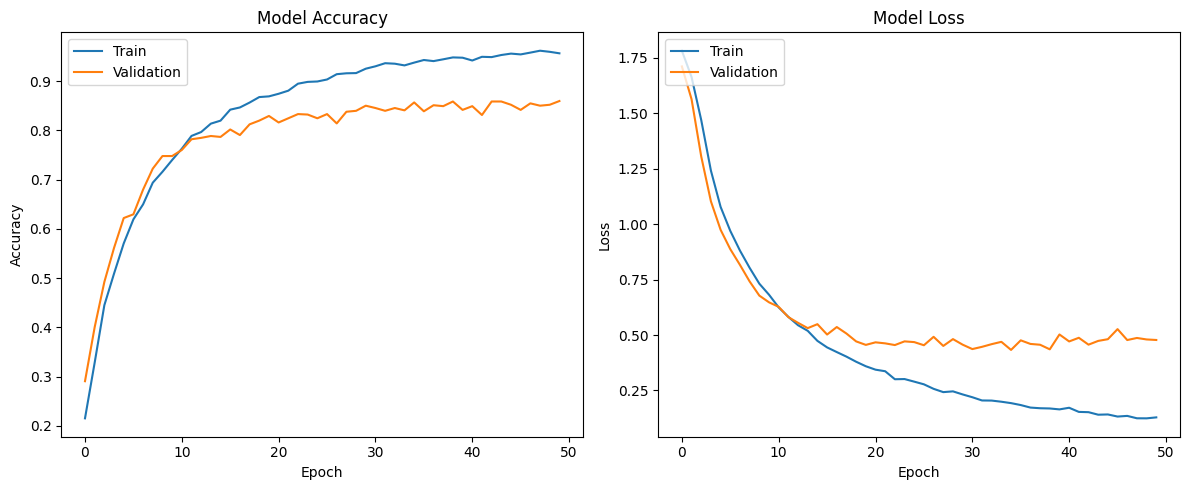

In [18]:


## 6. Visualize Results

# Plot training history and confusion matrices.

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
if 'val_accuracy' in history.history: # Check if validation accuracy exists
    plt.plot(history.history["val_accuracy"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
if 'val_loss' in history.history: # Check if validation loss exists
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()


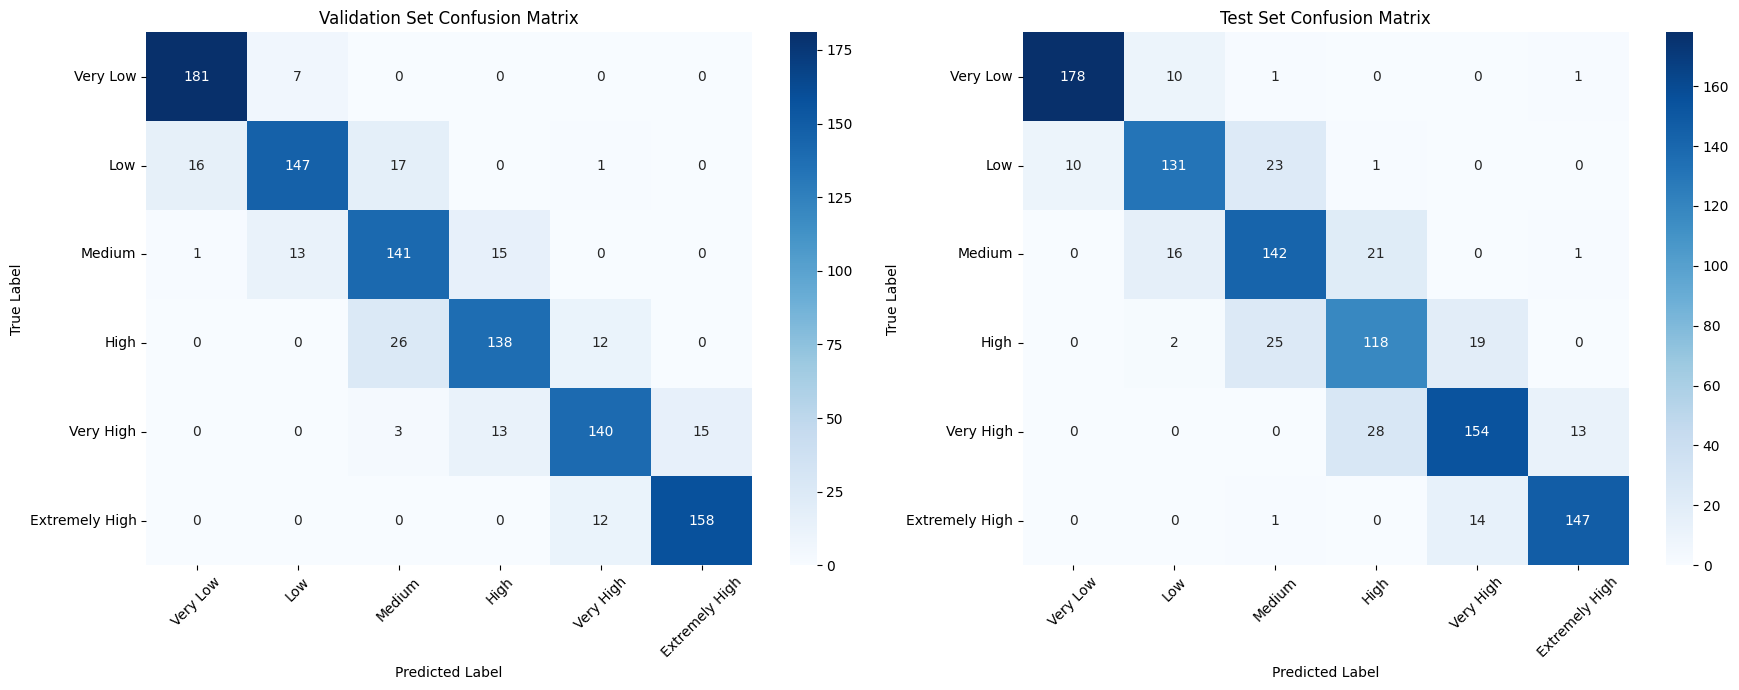

In [19]:



# Plot Confusion Matrix Heatmaps (Validation and Test)
plt.figure(figsize=(18, 7))

# Validation Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_display_names,
            yticklabels=class_display_names)
plt.title("Validation Set Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Test Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_display_names,
            yticklabels=class_display_names)
plt.title("Test Set Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


In [20]:



# === SUMMARY OF RESULTS ===
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Model trained successfully with 6 classes!")
print(f"Classes: Very Low, Low, Medium, High, Very High, Extremely High")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Macro F1 Score: {macro_f1:.4f}")
print("="*60)

print("\n--- End of Script ---")


FINAL RESULTS SUMMARY
Model trained successfully with 6 classes!
Classes: Very Low, Low, Medium, High, Very High, Extremely High
Validation Accuracy: 0.8570
Validation Macro F1 Score: 0.8557
Test Accuracy: 0.8239
Test Macro F1 Score: 0.8231

--- End of Script ---
